In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as t_data

In [2]:
from utils import WeatherDatasetSimple
from models import InterpolationModel, SRCNN
from model_eval import eval_model_single_frame, eval_results

In [3]:
device = 'cuda'

In [4]:
train_dataset = WeatherDatasetSimple('data/wind/LR_train', 'data/wind/HR_train', max_dataset_size=8448)
valid_dataset = WeatherDatasetSimple('data/wind/LR_val', 'data/wind/HR_val', max_dataset_size=1024)
test_dataset = WeatherDatasetSimple('data/wind/LR_test', 'data/wind/HR_test', max_dataset_size=1024)

In [5]:
batch_size = 16
train_dataloader = t_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = t_data.DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = t_data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
mns_lr, mns_hr = [], []
for x in train_dataset:
    mns_lr.append( np.mean(x[0], axis=(1,2)) )
    mns_hr.append( np.mean(x[1], axis=(1,2)) )

print("High Res data : mean ", np.mean(mns_hr, 0), ' std: ', np.std(mns_hr, 0) )
print(" Low Res data : mean ", np.mean(mns_lr, 0), ' std: ', np.std(mns_lr, 0) )

High Res data : mean  [0.5112902]  std:  [0.092385]
 Low Res data : mean  [0.5103885]  std:  [0.09374698]


Data at different channels have pretty similar distributions and is contained within [0; 1], so we decided not to standartidize it.

## Bicubic Interpolation

In [6]:
i_model = InterpolationModel().to(device)

In [7]:
result = eval_model_single_frame(i_model, test_dataloader, device=device, verbose=True)

Evaluation completed. Metrics: 
mse :  0.007246678818432883  +-  0.00636091728210495
mae :  0.060439967119236826  +-  0.02494474580512921
psnr :  22.404137259349227  +-  2.9376695680397322


## SRCNN

In [8]:
import os
import copy
from tqdm import tqdm

In [9]:
srcnn_model = SRCNN(num_channels=1).to(device)

In [10]:
lr = 1e-4
num_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam([
    {'params': srcnn_model.conv1.parameters()},
    {'params': srcnn_model.conv2.parameters()},
    {'params': srcnn_model.conv3.parameters(), 'lr': 0.1 * lr}
], lr=lr)
outputs_dir = 'Models/Baselines/TRAIN'

In [11]:
best_weights = copy.deepcopy(srcnn_model.state_dict())
best_epoch = 0
best_psnr = 0.0

In [13]:
for epoch in range(num_epochs):
    srcnn_model.train()

    with tqdm(total=(len(train_dataset) - len(train_dataset) % batch_size)) as t:
        t.set_description('epoch: {}/{}'.format(epoch, num_epochs - 1))
        cur_loss = 0.0
        for lr, hr in train_dataloader:
            lr = lr.to(device)
            hr = hr.to(device)

            hr_pred = srcnn_model(lr)

            loss = criterion(hr_pred, hr)
            optimizer.zero_grad()
            cur_loss += loss.item()  / (len(train_dataset) // batch_size)
            
            loss.backward()
            optimizer.step()

            t.set_postfix(loss='{:.6f}'.format(cur_loss))
            t.update(len(lr))

        #torch.save(model.state_dict(), os.path.join(outputs_dir, 'epoch_{}.pth'.format(epoch)))
        srcnn_model.eval()
        epoch_result = eval_model_single_frame(srcnn_model, valid_dataloader,  device=device)
        t.set_postfix({'train loss ': '{:.8f}'.format(cur_loss), 'evalPSNR' : epoch_result['psnr'], 'MAE' : epoch_result['mae'], 'MSE' : epoch_result['mse']} )

        if epoch_result['psnr'] > best_psnr:
            best_epoch = epoch
            best_psnr = epoch_result['psnr']
            best_weights = copy.deepcopy(srcnn_model.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, os.path.join(outputs_dir, 'SRCNN_best.pth'))

epoch: 0/99: 100%|█| 8448/8448 [00:20<00:00, 412.88it/s, train loss =0.00332575, evalPSNR=25.6, MAE=0.0432, MSE=0.0038]

best epoch: 0, psnr: 25.64


In [14]:
srcnn_model = SRCNN(num_channels=1).to(device)
srcnn_model.load_state_dict(torch.load('Models/Baselines/TRAIN/SRCNN_best.pth'))
srcnn_model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [15]:
eval_model_single_frame(srcnn_model, test_dataloader, device=device, verbose=True)

Evaluation completed. Metrics: 
mse :  0.0038144749002526623  +-  0.005006883154809919
mae :  0.04382079918104864  +-  0.023290635157392964
psnr :  25.605471628718078  +-  3.2910103060678924


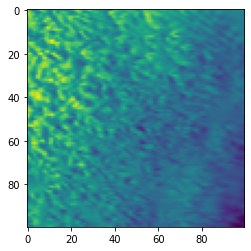

In [20]:
from PIL import Image
import matplotlib.pyplot as plt 


img_ideal = Image.open('data/wind/HR_test/va_57197_1.png')#.convert('RGB')
plt.imshow(img_ideal)

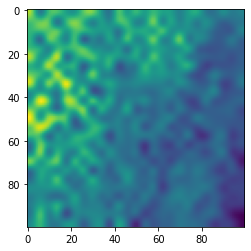

In [21]:
from PIL import Image
aa = torch.tensor([test_dataset[1][0]])
img_iterpolated = nn.functional.interpolate(aa, mode='bicubic', align_corners=False, scale_factor=4)[0][0].numpy()
plt.imsave('outputs/bicub.png', img_iterpolated, format='png')
plt.imshow(img_iterpolated)

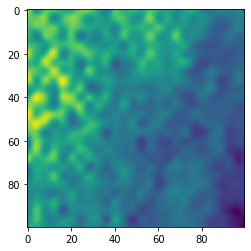

In [23]:
img_outp = srcnn_model(aa.to(device))[0][0].cpu().detach().numpy()
plt.imsave('outputs/srcnn.png', img_outp, format='png')
plt.imshow(img_outp)

## SRFBN

In [8]:
test_dataset = WeatherDatasetSimple('data/val_T2_V10_U10_d02_new_hr', 'Baseline_predicts/SRFBN')
check_dataloader = t_data.DataLoader(test_dataset, batch_size=1, shuffle=False)

result = eval_results(check_dataloader)
print("SRFBN model results: ")
print("MSE:  ", result['mse'])
print("MAE:  ", result['mae'])
print("PSNR: ", result['psnr'])

Interpolation model results: 
MSE:   0.00022177140316468976
MAE:   0.009790236856362954
PSNR:  29.71257377434382


## ESRGAN 

In [10]:
test_dataset = WeatherDatasetSimple('data/val_T2_V10_U10_d02_new_hr', 'Baseline_predicts/ESRGAN')
check_dataloader = t_data.DataLoader(test_dataset, batch_size=1, shuffle=False)

result = eval_results(check_dataloader)
print("ESRGAN model results: ")
print("MSE:  ", result['mse'])
print("MAE:  ", result['mae'])
print("PSNR: ", result['psnr'])

Interpolation model results: 
MSE:   0.0013496031888309233
MAE:   0.02381261536051019
PSNR:  23.814576119438854
